# Timeseries Trend Analysis
This notebook runs a simple trend analysis on the timeseries shown in the time series viewer:
https://proba-v-mep.esa.int/applications/time-series-viewer/app/app.html
It demonstrates how Spark can be used on the MEP Hadoop cluster, from within a notebook.
## Disclaimer
This notebook is not scientifically validated, only meant as a technical demonstration on a real world use case.

## Context

So some context first about the data we are going to manipulate.
* The dataset contains FAPAR data (Fraction of Absorbed Photosynthetically Active Radiation)
* The data was computed using raster data taken by a satelite
* Normally, there should be one measurement every 10 days for every zone and landcover.
* Due to external conditions (e.g. clouds), data can be missing.

## Goal
Our goal is pretty simple: we want to detect if there are any trends for each zone.

## General approach
We will proceed as follows:
1. Clean missing measurements from the original dataset
1. Group measurements by zone and landcover
1. For every zone:
  1. Do some cleaning for every landcover
  1. Combine the different landcovers data
  1. Remove seasonality by taking yearly averages
  1. Compute the trend
1. Plot the trends on a world map.

We will detail each step along the way.

If you run this script in the jupyterlab of terrascope, make sure to shut down all kernels before reconnecting and running this script, as the last cell will use a lot of memory.

In [1]:
import pyspark
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime, time

%matplotlib inline

Let's read the parquet file containing all our data, as follows:

In [2]:
from pyspark.conf import SparkConf
conf = SparkConf()
conf.set('spark.yarn.executor.memoryOverhead', 1024)
conf.set('spark.executor.memory', '4g')

The SparkContext 'sc' is our entry point to the Hadoop cluster. The sparkConf defines some parameters.

In [3]:
sc = pyspark.SparkContext(conf=conf)

In [4]:
sqlCtx = pyspark.SQLContext(sc)

Open a terminal, run `kinit` and supply your password to request a kerboros ticket.

In [5]:
!hdfs dfs -ls /tapdata/tsviewer/combined-stats/stats.parquet

Found 169 items
-rw-r--r--   3 mep_tsviewer vito          0 2017-03-22 00:20 /tapdata/tsviewer/combined-stats/stats.parquet/_SUCCESS
-rw-r--r--   3 mep_tsviewer vito   25357414 2017-03-22 00:07 /tapdata/tsviewer/combined-stats/stats.parquet/part-r-00000.parquet
-rw-r--r--   3 mep_tsviewer vito   25341813 2017-03-22 00:07 /tapdata/tsviewer/combined-stats/stats.parquet/part-r-00001.parquet
-rw-r--r--   3 mep_tsviewer vito   25344785 2017-03-22 00:07 /tapdata/tsviewer/combined-stats/stats.parquet/part-r-00002.parquet
-rw-r--r--   3 mep_tsviewer vito   25325074 2017-03-22 00:07 /tapdata/tsviewer/combined-stats/stats.parquet/part-r-00003.parquet
-rw-r--r--   3 mep_tsviewer vito   25382644 2017-03-22 00:07 /tapdata/tsviewer/combined-stats/stats.parquet/part-r-00004.parquet
-rw-r--r--   3 mep_tsviewer vito   25368452 2017-03-22 00:07 /tapdata/tsviewer/combined-stats/stats.parquet/part-r-00005.parquet
-rw-r--r--   3 mep_tsviewer vito   25338382 2017-03-22 00:07 /tapdata/tsviewer/combined-stats

In [6]:
data = sqlCtx.read.parquet("hdfs:/tapdata/tsviewer/combined-stats/stats.parquet")
data

DataFrame[landcover: string, zone: int, date: string, BIOPAR_ALB_BHV_V1: double, BIOPAR_ALB_BHV_V1_area: bigint, BIOPAR_ALB_BHV_V1_validArea: bigint, BIOPAR_ALB_DHV_V1: double, BIOPAR_ALB_DHV_V1_area: bigint, BIOPAR_ALB_DHV_V1_validArea: bigint, BIOPAR_BA_V1: double, BIOPAR_BA_V1_area: bigint, BIOPAR_BA_V1_validArea: bigint, BIOPAR_DMP: double, BIOPAR_DMP_area: bigint, BIOPAR_DMP_validArea: bigint, BIOPAR_FAPAR_V1: double, BIOPAR_FAPAR_V1_area: bigint, BIOPAR_FAPAR_V1_validArea: bigint, BIOPAR_FCOVER_V1: double, BIOPAR_FCOVER_V1_area: bigint, BIOPAR_FCOVER_V1_validArea: bigint, BIOPAR_LAI_V1: double, BIOPAR_LAI_V1_area: bigint, BIOPAR_LAI_V1_validArea: bigint, BIOPAR_NDVI_V1: double, BIOPAR_NDVI_V1_area: bigint, BIOPAR_NDVI_V1_validArea: bigint, BIOPAR_NDVI_V2: double, BIOPAR_NDVI_V2_area: bigint, BIOPAR_NDVI_V2_validArea: bigint, BIOPAR_SWI10_V3: double, BIOPAR_SWI10_V3_area: bigint, BIOPAR_SWI10_V3_validArea: bigint, BIOPAR_TOCR_B0: double, BIOPAR_TOCR_B0_area: bigint, BIOPAR_TOCR_B0

Next, we want to register this data in a temporary table so we can query it using Spark's SQLContext.

In [7]:
data.registerTempTable("data")

Now although we instructed Spark where the data was and to register it, it did not actually read anything. This is because Spark is lazy: it will postpone doing any task until it the last moment. Requesting data will force it to load it, as follows:

In [8]:
data.take(1)

[Row(landcover=u'Water_bodies', zone=3219, date=u'2007-11-01', BIOPAR_ALB_BHV_V1=0.14052462320017708, BIOPAR_ALB_BHV_V1_area=11163, BIOPAR_ALB_BHV_V1_validArea=11076, BIOPAR_ALB_DHV_V1=0.14695226555861848, BIOPAR_ALB_DHV_V1_area=11163, BIOPAR_ALB_DHV_V1_validArea=11076, BIOPAR_BA_V1=0.0009853981904505958, BIOPAR_BA_V1_area=11163, BIOPAR_BA_V1_validArea=11, BIOPAR_DMP=None, BIOPAR_DMP_area=None, BIOPAR_DMP_validArea=None, BIOPAR_FAPAR_V1=0.21222769551344417, BIOPAR_FAPAR_V1_area=11163, BIOPAR_FAPAR_V1_validArea=10995, BIOPAR_FCOVER_V1=0.11557305349856734, BIOPAR_FCOVER_V1_area=11163, BIOPAR_FCOVER_V1_validArea=10995, BIOPAR_LAI_V1=0.28491411937776656, BIOPAR_LAI_V1_area=11163, BIOPAR_LAI_V1_validArea=10995, BIOPAR_NDVI_V1=0.27314899691044103, BIOPAR_NDVI_V1_area=11163, BIOPAR_NDVI_V1_validArea=10995, BIOPAR_NDVI_V2=None, BIOPAR_NDVI_V2_area=None, BIOPAR_NDVI_V2_validArea=None, BIOPAR_SWI10_V3=None, BIOPAR_SWI10_V3_area=None, BIOPAR_SWI10_V3_validArea=None, BIOPAR_TOCR_B0=None, BIOPAR_TO

Using Spark's SQLContext, we can query our data with SQL-like expressions. Here we are interested in the *zone, landcover, date, FAPAR* and *area* columns.

We will also filter out unwanted rows by specifying that we do not want rows for which we do not have a *FAPAR* value.

In [11]:
data = sqlCtx.sql("SELECT zone, landcover, date date, BIOPAR_FAPAR_V1 fapar, BIOPAR_FAPAR_V1 " + 
                  "FROM data " +
                  "WHERE BIOPAR_FAPAR_V1 is not null").cache()
data.take(1)

[Row(zone=3219, landcover=u'Water_bodies', date=u'2006-08-11', fapar=0.29711740277250515, BIOPAR_FAPAR_V1=0.29711740277250515)]

As you can see, although **null** values have been filtered out, some **FAPAR** values still remain **nan**.
We can filter them out using the **filter** method from Spark. For that, we can either use the **DataFrame**'s method filter, or we can use the **DataFrame** as a regular **RDD**.

The difference is that the **DataFrame** contains **Row**s, for which we can refer to the columns with their names, whereas the **RDD** contains **tuple**s, where we have to select columns based on their index. However, with a regular **RDD**, we can pass any method we want to **filter, map, reduce, ...**, whereas with a **DataFrame**, we have to use pre-defined functions.

In [12]:
def fapar_not_nan(row):
    return row[3] is not None and not np.isnan(row[3])

withoutNaNs = data.rdd.filter(fapar_not_nan).cache()
withoutNaNs.take(1)

[Row(zone=3219, landcover=u'Water_bodies', date=u'2006-06-21', fapar=0.24140815792410703, BIOPAR_FAPAR_V1=0.24140815792410703)]

For grouping, we could use spark's *groupBy* method, or we could first *map* our data to a *(Key, Value)* pair and use the *groupByKey* method. We will use the latter method as we have more fined control over what goes into *Value*.

In [13]:
def by_zone(row):
    return ((row[0]), (row[1], row[2], row[3], row[4]))

by_zone = withoutNaNs.map(by_zone).groupByKey().cache()
by_zone.take(1)

[(672, <pyspark.resultiterable.ResultIterable at 0x601efd0>)]

The result is a list of pairs *(Zone, Values)* where *Values* is a list containing all the values for the specific *Zone* we grouped by.

Spark will combine the different values into a *ResultIterable* object, not really suited for the analysis we will be doing. Instead, we are going to use Pandas and Numpy. So first thing we want to do is to convert our *ResultIterable* into an actual *Pandas* DataFrame.

In [14]:
def iterable_to_pd(row):
    return (row[0], pd.DataFrame(list(row[1]), columns=["landcover", "date", "fapar", "area"]))

by_zone = by_zone.map(iterable_to_pd).cache()
by_zone.take(1)

[(672,                                                landcover        date  \
  0        Tree_cover_broadleaved_evergreen_closed_to_open  2000-07-11   
  1        Tree_cover_broadleaved_evergreen_closed_to_open  2006-11-01   
  2        Tree_cover_broadleaved_evergreen_closed_to_open  2010-11-21   
  3        Tree_cover_broadleaved_evergreen_closed_to_open  2011-02-11   
  4                Mosaic_herbaceous_cover__tree_and_shrub  2000-06-01   
  5                Mosaic_herbaceous_cover__tree_and_shrub  2004-06-21   
  6                Mosaic_herbaceous_cover__tree_and_shrub  2010-10-11   
  7                Mosaic_herbaceous_cover__tree_and_shrub  2011-01-01   
  8                Mosaic_herbaceous_cover__tree_and_shrub  2015-01-21   
  9          Sparse_vegetation_tree_shrub_herbaceous_cover  2000-04-21   
  10         Sparse_vegetation_tree_shrub_herbaceous_cover  2006-08-11   
  11         Sparse_vegetation_tree_shrub_herbaceous_cover  2012-12-01   
  12         Sparse_vegetation_tr

Now that we are ready to write our *Combine* task, let's detail the algorithm we are going to write to process each *zone*:

1. Group the dataset by landcover, and for each:
  1. Resample the data monthly (instead of 10-daily) with padding in order to fill some void if there are any
1. Reweight the **FAPAR** values by the area the landcover takes over the **total area**
1. Regroup the dataset by date and take the (monthly) sum
1. Resample the data yearly and remove the 1st and last year of data (to only include full years)

In [15]:
def combine_fapar(zone):
    series = zone[1]
    series["date"] = pd.to_datetime(series["date"])
    series = series.set_index("date")
    
    # Group the dataset by landcover, and for each:
    by_landcover = series.groupby("landcover")
    
    # Resample the data monthly (instead of 10-daily) with padding in order to fill some void if there are any
    by_landcover = by_landcover.resample("1m", how="mean").fillna(method='pad')
    series = by_landcover.reset_index()
    
    # Reweight the FAPAR values by the area the landcover takes over the total area
    total_area = by_landcover["area"].mean().sum()
    series["fapar"] *= series["area"] / total_area
    series = series.drop("area", axis=1)
    
    # Regroup the dataset by date and take the (monthly) sum
    series = series.groupby("date").sum()
    
    # Resample the data yearly and remove the 1st and last year of data (to only include full years)
    yearly_sum = pd.DataFrame(series["fapar"].resample("12m", "mean")[1:-1])
    
    return (zone[0], series, yearly_sum)

combined = by_zone.map(combine_fapar).cache()
combined.take(1)

[(672,                 fapar
  date                 
  1999-01-31   9.717959
  1999-02-28   8.868936
  1999-03-31  10.370095
  1999-04-30  12.420800
  1999-05-31  12.032194
  1999-06-30   9.968254
  1999-07-31   9.284237
  1999-08-31   8.657068
  1999-09-30   6.982681
  1999-10-31   5.440120
  1999-11-30   5.537638
  1999-12-31   8.929892
  2000-01-31  10.512340
  2000-02-29  11.302637
  2000-03-31  13.014589
  2000-04-30  14.539168
  2000-05-31  14.625471
  2000-06-30  13.036348
  2000-07-31  10.837346
  2000-08-31   9.071030
  2000-09-30   6.932734
  2000-10-31   8.162503
  2000-11-30   7.231002
  2000-12-31  10.725195
  2001-01-31  11.366307
  2001-02-28  10.276144
  2001-03-31  10.517193
  2001-04-30  10.990723
  2001-05-31  10.960789
  2001-06-30  11.189507
  ...               ...
  2014-10-31   8.205650
  2014-11-30   8.801627
  2014-12-31  11.202606
  2015-01-31  10.501179
  2015-02-28   9.387215
  2015-03-31  10.382771
  2015-04-30  11.646911
  2015-05-31  11.264060
  2015-06-3

Finally, we can compute the trend using a linear regression (OLS).

In [16]:
def min_years(datas):
    return len(datas[2]) >=5 

def ols(datas):    
    yearly_series = datas[2]
    x, y = yearly_series.index.astype(int) // (10**9 * 60 * 24 * 30), yearly_series["fapar"]
    X = np.c_[np.ones(len(x)), x]
    return (datas[0], datas[1], datas[2], np.linalg.pinv(X).dot(y))

trends = combined.filter(min_years).map(ols).cache()

Next we will plot the trends.
We are interested in the highest and lowest trends in our data.

Let's define our plotting function and plot the trends by descending order.

In [21]:
#copy auxiliary data from hdfs
!hdfs dfs -copyToLocal /tapdata/GAUL2013/zonecodes.csv ./

17/03/22 13:25:52 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [23]:
zonecodes = pd.read_csv("./zonecodes.csv")
def plotTopTrends(trendsCollected):
    for zone, series, yearly_series, trend in trendsCollected:
        if not np.isnan(trend[0]) and not np.isnan(trend[1]):
            codes = zonecodes[zonecodes['ADM1_CODE'] == zone][["ADM0_NAME", "ADM1_NAME"]]
            codes["Trend"] = trend[1]
            print codes
                
            pdf = series.copy()
            pdf["ols"] = pdf.index.astype(int) / (10**9 * 60 * 24 * 30) * trend[1] + trend[0]
            pdf[["fapar", "ols"]].plot(figsize=(16,4))

            #sns.regplot(x="unix_date", y="fapar", data=series, scatter=False)
            plt.show()

          ADM0_NAME                          ADM1_NAME     Trend
117  American Samoa  Administrative unit not available  0.001467


/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


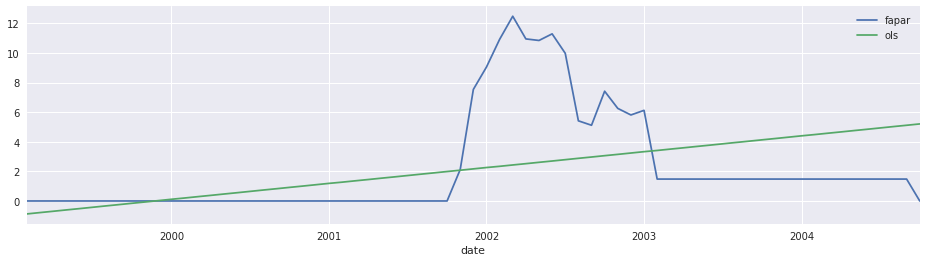

    ADM0_NAME                  ADM1_NAME     Trend
793     Egypt  Al Bahr/al Ahmar (redsea)  0.000554


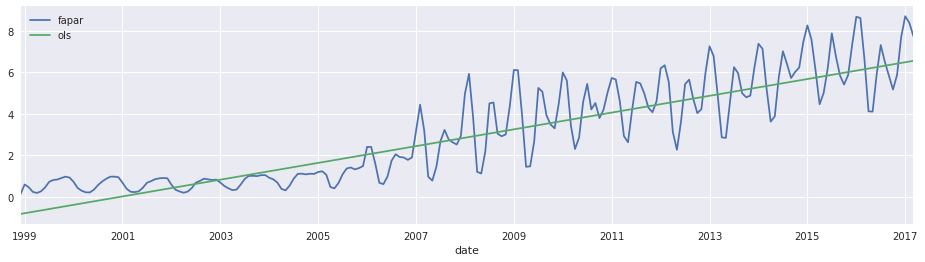

     ADM0_NAME                          ADM1_NAME     Trend
1311  Kiribati  Administrative unit not available  0.000551


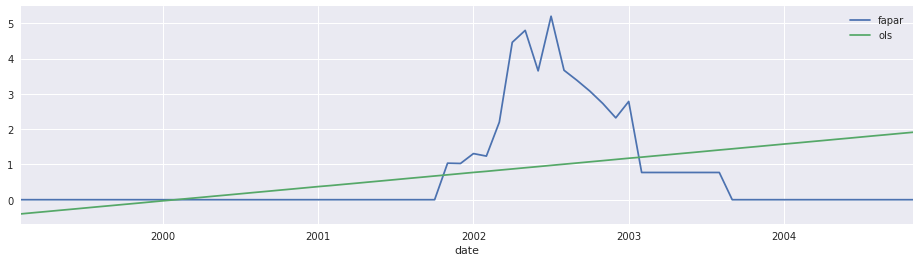

       ADM0_NAME ADM1_NAME     Trend
1662  Montserrat  Plymouth  0.000495


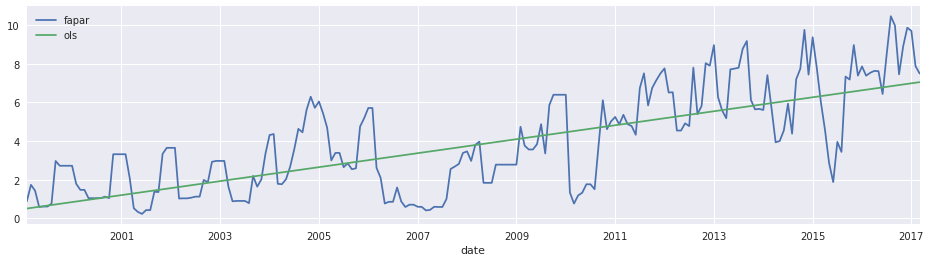

     ADM0_NAME ADM1_NAME     Trend
1827  Pakistan    Punjab  0.000426


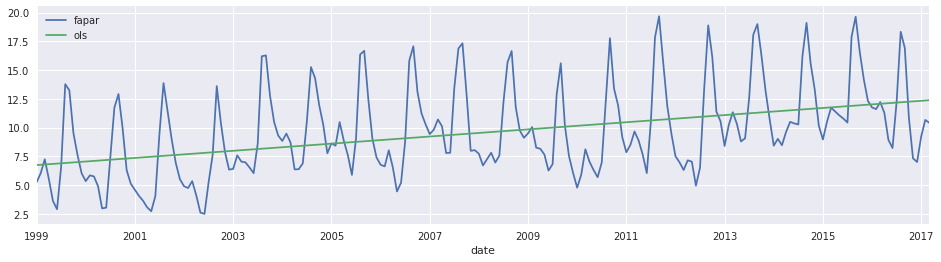

     ADM0_NAME  ADM1_NAME     Trend
1101     India  Rajasthan  0.000421


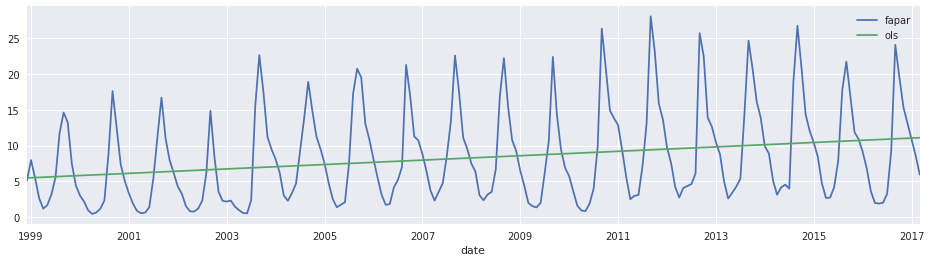

    ADM0_NAME                 ADM1_NAME     Trend
805     Egypt  As Ismailiyah (ismailia)  0.000421


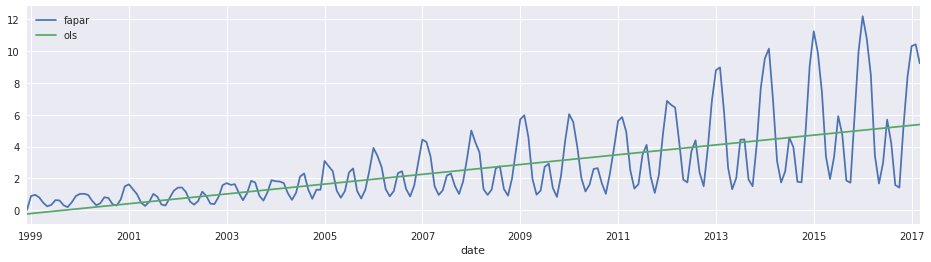

    ADM0_NAME ADM1_NAME     Trend
104   Algeria     Saida  0.000418


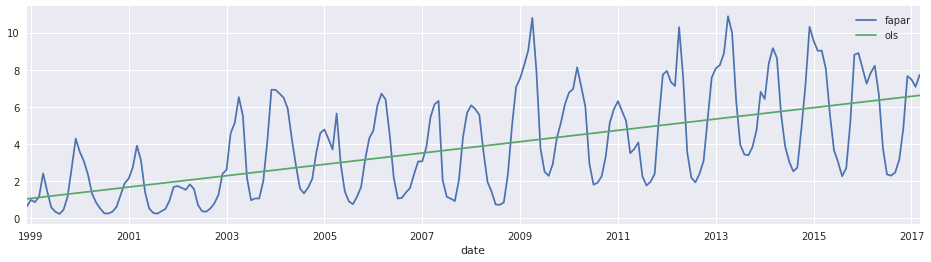

    ADM0_NAME ADM1_NAME     Trend
112   Algeria    Tiaret  0.000405


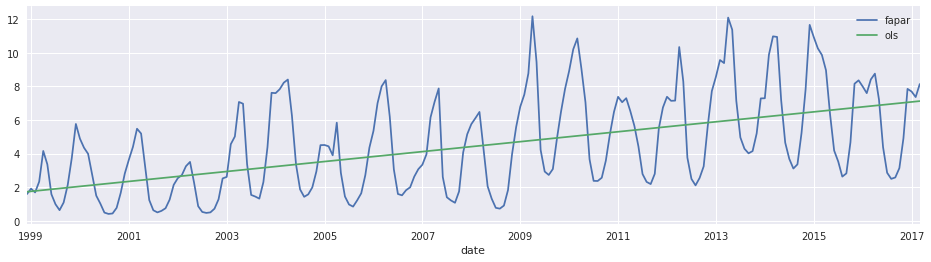

     ADM0_NAME ADM1_NAME   Trend
2561    Turkey   Denizli  0.0004


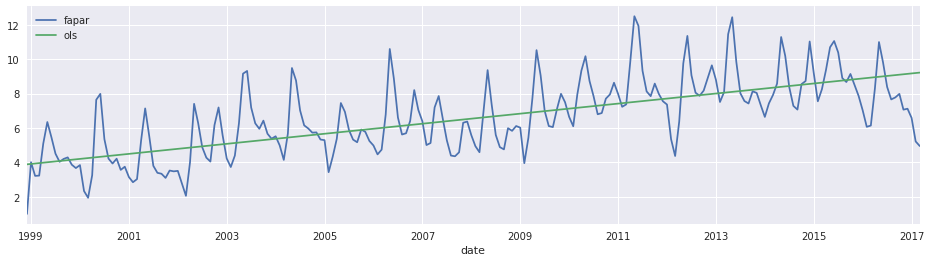

In [24]:
plotTopTrends(trends.sortBy(lambda x: x[3][1], ascending=False).take(10))

            ADM0_NAME                          ADM1_NAME     Trend
574  Christmas Island  Administrative unit not available -0.001041


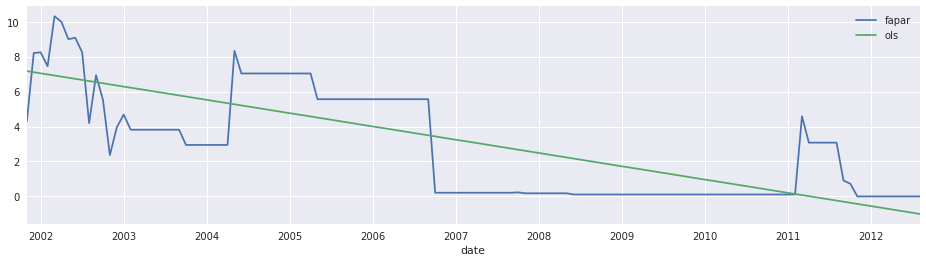

            ADM0_NAME                          ADM1_NAME     Trend
904  French Polynesia  Administrative unit not available -0.000726


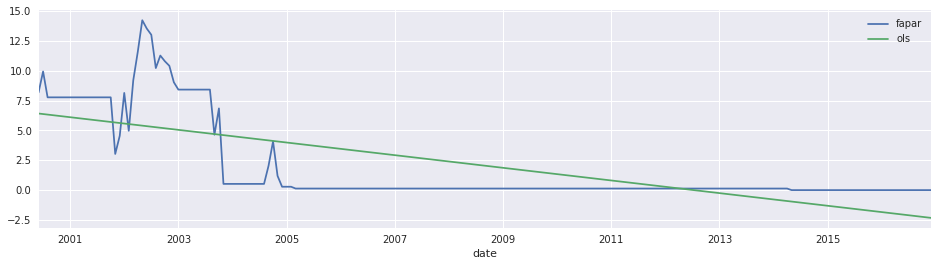

       ADM0_NAME   ADM1_NAME     Trend
3314  Martinique  La Trinite -0.000519


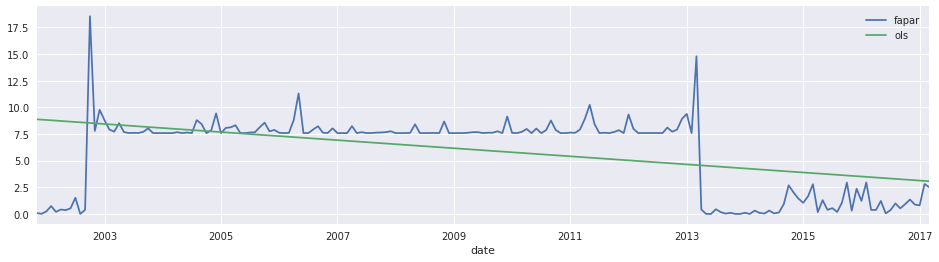

    ADM0_NAME ADM1_NAME     Trend
731  Djibouti     Obock -0.000301


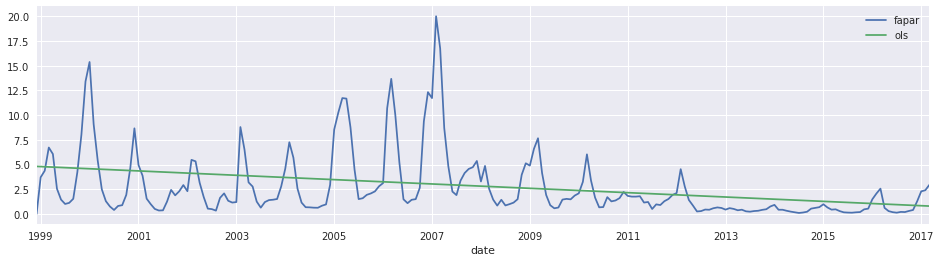

     ADM0_NAME ADM1_NAME     Trend
3102    Guinea   Conakry -0.000285


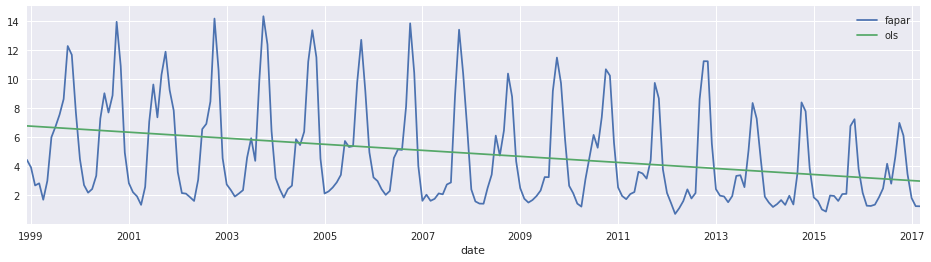

    ADM0_NAME     ADM1_NAME     Trend
984   Grenada  St. George's -0.000231


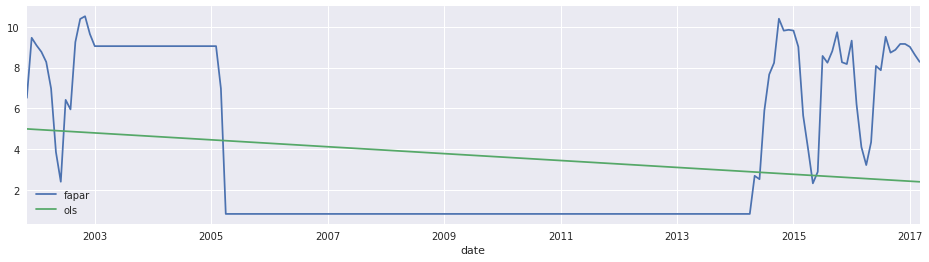

       ADM0_NAME  ADM1_NAME     Trend
1674  Mozambique  Inhambane -0.000223


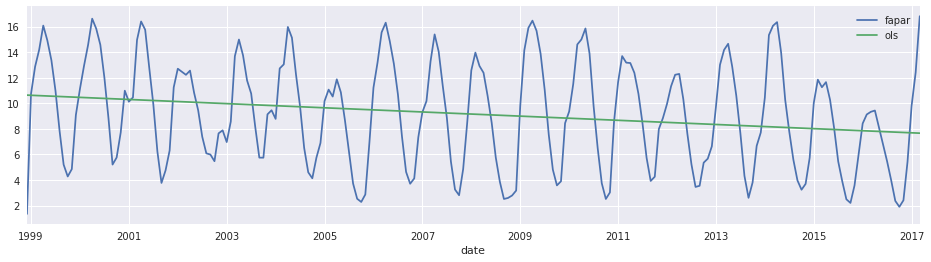

       ADM0_NAME ADM1_NAME     Trend
1676  Mozambique    Maputo -0.000222


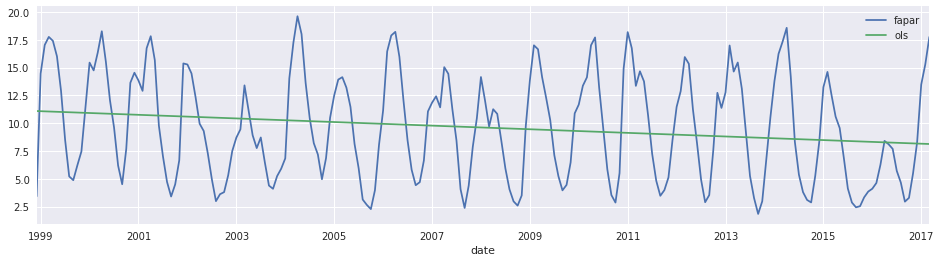

In [25]:
plotTopTrends(trends.sortBy(lambda x: x[3][1], ascending=True).take(10))

Now we can create a world map and color each zone by its trend.
First, let's only take each region and its corresponding trend.

In [26]:
def mean_trends(zone):
    return (zone[0], zone[3][1])

trend_by_zone = dict(trends.map(mean_trends).filter(lambda x: not np.isnan(x[1])).collect())

We will also draw a colormap but by default *matplotlib* will center the colormap based on the mean of the values.
We would like to center the colormap on 0.0, so as to fill zones with no trend (0) in yellow, zones with an upwards trend in green and zones with a downwards trend in red.

We define a function to shift the colormap and center it around the point we want.

In [27]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

Now we can actually draw the map.

In [32]:
!mkdir GAUL2013
!hdfs dfs -copyToLocal /tapdata/GAUL2013/GAUL1* ./GAUL2013/
def plot_map(zones_trend, lllon=-180, lllat=-90, urlon=180, urlat=90): 
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, 
                  urcrnrlon=urlon, urcrnrlat=urlat, 
                  resolution='c', 
                  projection='cyl')

    #map.drawmapboundary(fill_color='aqua')
    #map.fillcontinents(color='#ddaa66', lake_color='aqua')
    #map.drawcoastlines()

    map.readshapefile('./GAUL2013/GAUL1', 'GAUL1')

    patches = []
    colors = []
    for info, shape in zip(map.GAUL1_info, map.GAUL1):
        zone_trend = zones_trend.get(info['ADM1_CODE'])
        if zone_trend is not None:
            patches.append( Polygon(np.array(shape), True ))
            colors.append(zone_trend)

    vmax = np.percentile(colors, 95)
    vmin = np.percentile(colors, 5)
    midpoint = 1 - vmax/(vmax + abs(vmin))
    colormap = shiftedColorMap(plt.get_cmap('RdYlGn'), midpoint=midpoint, name='shifted')

    pc = PatchCollection(patches, cmap=colormap, linewidths=1., zorder=2)
    pc.set_array(np.array(colors))
    pc.set_clim([vmin, vmax])
    ax.add_collection(pc)
    plt.colorbar(pc)

    plt.show()


17/03/22 13:33:13 WARN hdfs.DFSClient: DFSInputStream has been closed already
17/03/22 13:33:13 WARN hdfs.DFSClient: DFSInputStream has been closed already
17/03/22 13:33:13 WARN hdfs.DFSClient: DFSInputStream has been closed already
17/03/22 13:33:13 WARN hdfs.DFSClient: DFSInputStream has been closed already
17/03/22 13:33:14 WARN hdfs.DFSClient: DFSInputStream has been closed already
17/03/22 13:33:14 WARN hdfs.DFSClient: DFSInputStream has been closed already
17/03/22 13:33:14 WARN hdfs.DFSClient: DFSInputStream has been closed already


This is what it looks like worldwide.

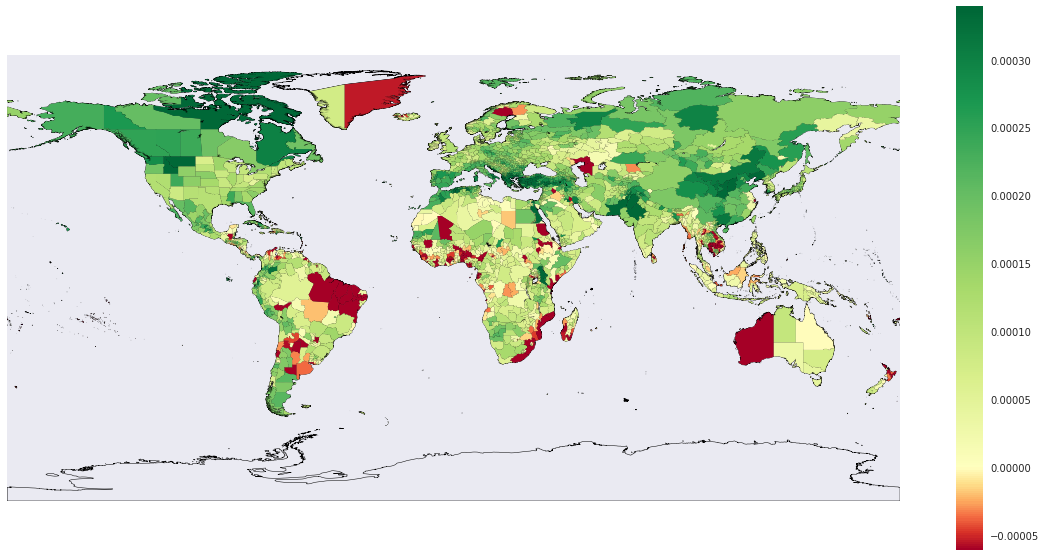

In [33]:
plot_map(trend_by_zone)

Europe:

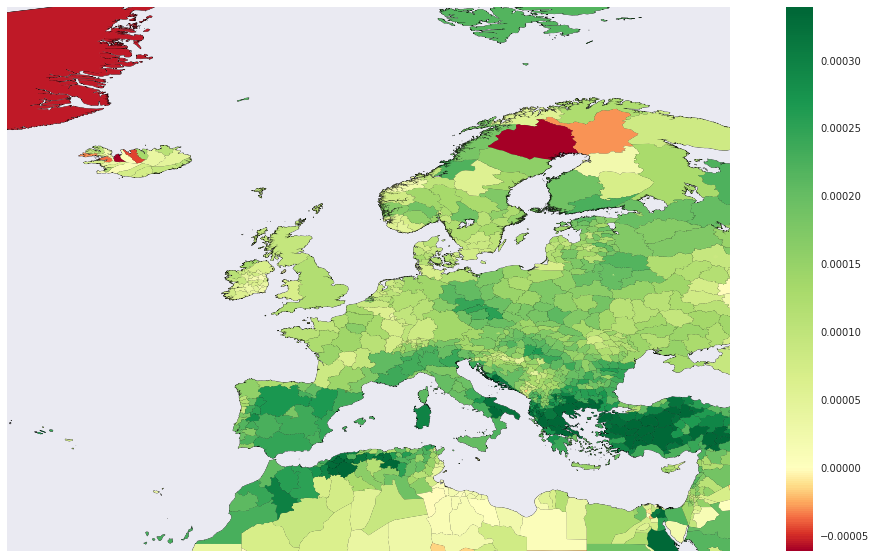

In [34]:
plot_map(trend_by_zone, lllon=-31.5, lllat=27, urlon=39, urlat=80)

Africa:

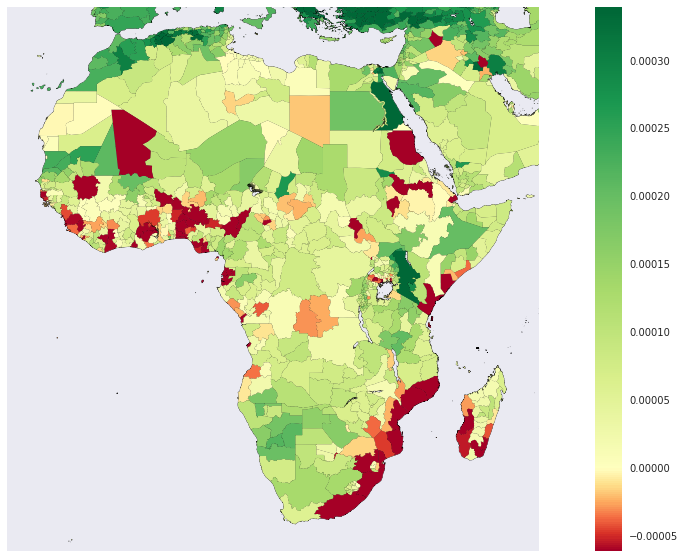

In [35]:
plot_map(trend_by_zone, lllon=-21.6, lllat=-38.7, urlon=55.2, urlat=39.8)